# COSC2671 Social Media and Network Analytics

## Workshop 4

Jeffrey Chan, RMIT University, 2023

In [22]:
# importing packages and nltk data libraries
import string
import json
import codecs
import re

import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')

from colorama import Fore, Back, Style
import pandas as pd
import matplotlib.pyplot as plt

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\HP\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [23]:
# load the twitter processing python class for use
# for those code that we repeatingly use but doesn't change much, or only change due to input, it is good to write them as
# functions and call later, which we are doing here.
# As the weeks goes by, we will increasingly do and make use of the benefits of scripts but also the interactivity of
# interactive Jupyter notebooks
%load_ext autoreload
%autoreload 1

# we are importing RedditProcessing.py and its contents
%aimport RedditProcessing

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Approach 1: Use counts of positive and negative words to calculate the sentiment.

This has 2 helper functions computerSentiment() and printColouredTokens().

Complete the parts with TODO for the workshop.

In [24]:
def computeSentiment(lTokens, setPosWords, setNegWords):
    """
    Compute the overall sentiment of the list of tokens in lTokens, using the countWordSentimentAnalysis approach.
    
    @param lTokens: List of tokens to calculate the overall sentiment for.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    
    @returns Sentiment score for lTokens.
    """
    
    #
    # TODO: compute the sentiment 
    # Answer below.
    #
                
    # TODO: count the number of positive words (hint: use setPosWords)
    posNum = len([tok for tok in lTokens if tok in setPosWords])

    # TODO: count the number of negative words (hint: use setNegWords)
    negNum = len([tok for tok in lTokens if tok in setNegWords])

    # TODO: compute the sentiment value
    # replace the right hand side with the computed value of sentiment 
    # the '0' value is currently a placeholder
    sentiment = posNum - negNum
                
                
    #
    # End of TODO part
    #
    
    return sentiment


In [25]:
def printColouredTokens(lTokens, setPosWords, setNegWords, sentiment):
    """
    Print out the tokens in different colours, according to sentiment.
    If positive, in red.
    If negative, in blue.
    Otherwise no colouring.
    
    @param lTokens: List of tokens to print and colour.
    @param setPosWords: Set of positive words.
    @param setNegWords: Set of negative words.
    @param sentiment: Sentiment score of list of tokens.
    """
        
    for token in lTokens:
        if token in setPosWords:
            print(Fore.RED + token + ', ', end='')
        elif token in setNegWords:
            print(Fore.BLUE + token + ', ', end='')
        else:
            print(Style.RESET_ALL + token + ', ', end='')

    print(': {}'.format(sentiment))
    

In [26]:
def countWordSentimentAnalysis(setPosWords, setNegWords, sTweetsFilename, bPrint, redditProcessor):
    """
    Basic sentiment analysis.  Count the number of positive words, count the negative words, overall polarity is the
    difference in the two numbers.

    @param setPosWords: set of positive sentiment words
    @param setNegWords: set of negative sentiment words
    @param sFilename: name of input file containing a json formated dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param redditProcessor: RedditProcessing object, used to pre-process each tweet.

    @returns: list of reddit posts, in the format of [date, sentiment]
    """


    lSentiment = []
    # open file and process reddit submissions and comments, one by one
    with open(sTweetsFilename, 'r') as f:
        redditDump = json.load(f)
        
        for submission in redditDump['submissions']:
            postText = submission['title']
            postDate = submission['created']
            
            # pre-process the reddit post text
            lTokens = redditProcessor.process(postText)
            # from where this redditProcessor comes from?
            
            # compute sentiment
            sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
                
            # save the date and sentiment of each reddit post (used for time series)
            lSentiment.append([pd.to_datetime(postDate, unit='s'), sentiment])

            # if we are printing, each token is printed and coloured according to red if positive word, and blue
            # if negative
            if bPrint:
                printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)
                
            # process the comments
            for comment in submission['comments']:
                postText = comment['text']
                postDate = comment['created']
                
                # pre-process the tweet text
                lTokens = redditProcessor.process(postText)
            
                # compute sentiment
                sentiment = computeSentiment(lTokens, setPosWords, setNegWords)
                
                # save the date and sentiment of each tweet (used for time series)
                lSentiment.append([pd.to_datetime(postDate,unit='s'), sentiment])

                # if we are printing, each token is printed and coloured according to if the are positive or negative 
                # sentiment
                if bPrint:
                    printColouredTokens(lTokens, setPosWords, setNegWords, sentiment)


    return lSentiment


### Approach 2: Vader based approach to sentiment analysis.

In [27]:
def vaderPrintTokens(lTokens, dSentimentScores):
    """
    Print out the tokens and sentiment score.
    
    @param lTokens: List of tokens to print and colour.
    @dSentimentScores: Dictionary of sentiment from Vader.

    """
    print(*lTokens, sep=', ')
    for cat,score in dSentimentScores.items():
        print('{0}: {1}, '.format(cat, score), end='')
    print()

In [28]:
def vaderSentimentAnalysis(sTweetsFilename, bPrint, tweetProcessor):
    """
    Use Vader lexicons instead of a raw positive and negative word count.

    @param sTweetsFilename: name of input file containing a json formated tweet dump
    @param bPrint: whether to print the stream of tokens and sentiment.  Uses colorama to highlight sentiment words.
    @param tweetProcessor: TweetProcessing object, used to pre-process each tweet.

    @returns: list of tweets, in the format of [date, sentiment]
    """

    # this is the vader sentiment analyser, part of nltk
    sentAnalyser = SentimentIntensityAnalyzer()


    lSentiment = []
    # open file and process tweets, one by one
    with open(sTweetsFilename, 'r') as f:
        redditDump = json.load(f)
        
        for submission in redditDump['submissions']:
            postText = submission['title']
            postDate = submission['created']
            
            # pre-process the post text
            lTokens = redditProcessor.process(postText)

            # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
            # see workshop sheet for what dSentimentScores holds
            dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

            # save the date and sentiment of each post (used for time series)
            lSentiment.append([pd.to_datetime(postDate, unit='s'), dSentimentScores['compound']])

            # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
            # of positive and negative words, we cannot use colorama to label each token
            if bPrint:
                vaderPrintTokens(lTokens, dSentimentScores)
                
                
            # process the comments
            for comment in submission['comments']:
                postText = comment['text']
                postDate = comment['created']
                
                # pre-process the post text
                lTokens = redditProcessor.process(postText)

                # this computes the sentiment scores (called polarity score in nltk, but mean same thing essentially)
                # see workshop sheet for what dSentimentScores holds
                dSentimentScores = sentAnalyser.polarity_scores(" ".join(lTokens))

                # save the date and sentiment of each post (used for time series)
                lSentiment.append([pd.to_datetime(postDate, unit='s'), dSentimentScores['compound']])

                # if we are printing, we print the tokens then the sentiment scores.  Because we don't have the list
                # of positive and negative words, we cannot use colorama to label each token
                if bPrint:
                    # print(postText)
                    vaderPrintTokens(lTokens, dSentimentScores)
                    
                    
    return lSentiment

Arguments for this notebook
Modify as needed if you want to do similar analaysis for other purposes

In [29]:
# input file of set of postive words
posWordFile = 'positive-words.txt'
# input file of set of negative words
negWordFile = 'negative-words.txt'
# input file of set of reddit posts (json format)
redditFile = 'nvidia_stock_data.json'
# flag to determine whether to print out tweets and their sentiment
flagPrint = True
# specify the approach to take, one of [count, vader]
# change this to use a different sentiment approach
approach = 'vader'

Then following calls the functions we have written above. First do the pre-processing, then calls the functions to do the sentiment analysis.

In [30]:
# construct the reddit pro-processing object
# use tweet tokenizer
tweetTokenizer = TweetTokenizer()
lPunct = list(string.punctuation)
# standard 'English' stopwords plus we want to remove things like 'rt' (retweet) etc
lStopwords = stopwords.words('english') + lPunct + ['rt', 'via', '...', '…', '"', "'", '`']

# call the RedditProcessing python script
redditProcessor = RedditProcessing.RedditProcessing(tweetTokenizer, lStopwords)


# load set of positive words
lPosWords = []
with open(posWordFile, 'r', encoding='utf-8', errors='ignore') as fPos:
    for sLine in fPos:
        lPosWords.append(sLine.strip())

setPosWords = set(lPosWords)


# load set of negative words
lNegWords = []
with codecs.open(negWordFile, 'r', encoding='utf-8', errors='ignore') as fNeg:
    for sLine in fNeg:
        lNegWords.append(sLine.strip())

setNegWords = set(lNegWords)

In [31]:
# compute the sentiment
# to change method, update parameter settings, particularly the variable 'approach' and rerun the parameter setting cell,
# and also this cell
lSentiment = []
if approach == 'count':
    lSentiment = countWordSentimentAnalysis(setPosWords, setNegWords, redditFile, flagPrint, redditProcessor)
elif approach == 'vader':
    lSentiment = vaderSentimentAnalysis(redditFile, flagPrint, redditProcessor)

funny, story, nvda, made, multi, millionaire
neg: 0.0, neu: 0.633, pos: 0.367, compound: 0.4404, 
awesome, story, congrats, ps, i'd, find, dill, hole's, number, give, call, say, thank, ;-)
neg: 0.0, neu: 0.404, pos: 0.596, compound: 0.9062, 
feels, holding, nvda, right
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
know, bet, earnings, amazing, still, drop
neg: 0.212, neu: 0.404, pos: 0.384, compound: 0.4019, 
108
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
earnings, might, bring, us, back, 110, ’, lucky
neg: 0.0, neu: 0.682, pos: 0.318, compound: 0.4215, 
jensen, huang, annual, shareholder, meeting, notes
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 
assume, 25, gpu's, meant, 25, less, one, percent
neg: 0.0, neu: 1.0, pos: 0.0, compound: 0.0, 

neg: 0.0, neu: 0.0, pos: 0.0, compound: 0.0, 
jensen, fuckin, mesiah, jensen, al, gaib, surrender, nvda, enter, tendie, paradise
neg: 0.0, neu: 0.704, pos: 0.296, compound: 0.6369, 
video, nvidia, ceo, entering, earnings, call, today
neg: 0.0,

Complete the code for the following cell, for the timeseries part.

C:\Users\HP\AppData\Local\Temp\ipykernel_19696\1221487185.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  newSeries = series.resample('1H').sum()


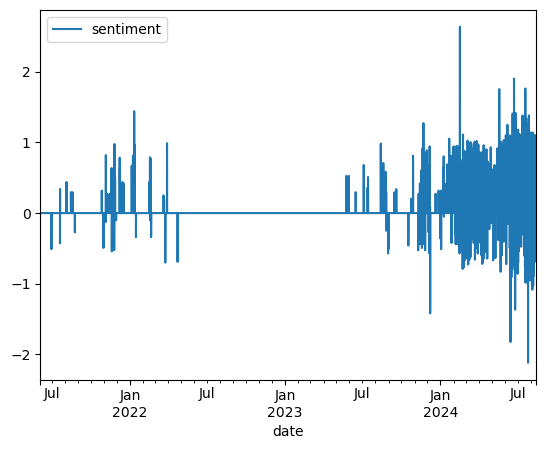

In [35]:
#
# TODO: timeseries part
#

# determine if we should output a time series of sentiment scores across time
# TODO: write code to display the time series (delete 'pass' below when you do)

# we are using pandas for this, but first we need to get it into a pandas data frame structure
series = pd.DataFrame(lSentiment, columns=['date', 'sentiment'])
# tell pandas that the date column is the one we use for indexing (or x-axis)
series.set_index('date', inplace=True)
# pandas makes a guess at the type of the columns, but to make sure it doesn't get it wrong, we set the sentiment
# column to floats
series[['sentiment']] = series[['sentiment']].apply(pd.to_numeric)

# This step is not necessary, but pandas has a neat function that allows us to group the series at different
# resultion.  The 'how=' part tells it how to group the instances.  In this example, it sames we want to group
# by day, and add up all the sentiment scores for the same day and create a new time series called 'newSeries'
# with this day resolution
# TODO: play with this for different resolution, '1H' is by hour, '1M' is by minute etc
newSeries = series.resample('1H').sum()
# this plots and shows the time series
newSeries.plot()
plt.show()